# Imports

In [1]:
from collections import Counter
import os
import sys

from keras import backend as K
from keras.models import Model
from keras.layers import Activation, concatenate, CuDNNLSTM, Dense, dot, Dropout, Flatten, Input, \
                         Lambda, multiply, Permute, RepeatVector, Reshape, TimeDistributed
from keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 170028219909755335
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15332678435257642443
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Config

In [3]:
STORIES_DIR = 'data/cnn/stories/'
story_files = os.listdir(STORIES_DIR)

In [4]:
n_files = len(story_files)
print('Stories in directory: %d' % n_files)

Stories in directory: 92579


In [5]:
characters = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
    'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.', '?', '!',
    ' ', '-', "'", '"', ':', ';', '/', '%', '&', '$', '€', '£', '@',
    '#', '*', '+', '=', '^', '(', ')', '[', ']', '{', '}', '<', '>',
    '_', '~', '|', '\t', '\n'
]

In [6]:
n_characters = len(characters)
n_characters

96

In [7]:
STORIES_TO_PARSE = 10000
MAX_STORY_CHARS_TO_CONSIDER = 1500
MAX_SUMMARY_CHARS_TO_CONSIDER = 250
LSTM_LATENT_DIM = 512
BATCH_SIZE = 50
EPOCHS = 100
BATCHES_PER_LOSSCALC = 10

# Generate Char Dicts

In [8]:
%%time
idx_2_char = {}
char_2_idx = {}
for i, char in enumerate(characters):
    idx_2_char[i] = char
    char_2_idx[char] = i
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 73.4 µs


# Configure NNs

## Training

In [9]:
encoder_inputs = Input(shape=(MAX_STORY_CHARS_TO_CONSIDER, n_characters),
                       name='encoder_inputs')

encoder_1 = CuDNNLSTM(
    units=LSTM_LATENT_DIM,
    return_sequences=True,
    return_state=True,
    name='encoder_1'
)
encoder_1_outputs, encoder_1_state_h, encoder_1_state_c = encoder_1(encoder_inputs)
encoder_1_state_h = Dropout(0.5, name='encoder_1_state_h')(encoder_1_state_h)
encoder_1_state_c = Dropout(0.5, name='encoder_1_state_c')(encoder_1_state_c)
encoder_1_states = [encoder_1_state_h, encoder_1_state_c]
# encoder_1_outputs = Dropout(0.5, name='encoder_1_outputs')(encoder_1_outputs)

encoder_2 = CuDNNLSTM(
    units=LSTM_LATENT_DIM,
    return_sequences=True,
    return_state=True,
    name='encoder_2'
)   
encoder_2_outputs, encoder_2_state_h, encoder_2_state_c = encoder_2(encoder_1_outputs)
encoder_2_state_h = Dropout(0.5, name='encoder_2_state_h')(encoder_2_state_h)
encoder_2_state_c = Dropout(0.5, name='encoder_2_state_c')(encoder_2_state_c)
encoder_2_states = [encoder_2_state_h, encoder_2_state_c]
encoder_2_outputs = Dropout(0.5, name='encoder_2_outputs')(encoder_2_outputs)

decoder_inputs = Input(shape=(None, n_characters), name='decoder_inputs')
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_1 = CuDNNLSTM(
    units=LSTM_LATENT_DIM, 
    return_sequences=True,
    return_state=True,
    name='decoder_1'
)
decoder_1_outputs, decoder_1_state_h, decoder_1_state_h = decoder_1(
    decoder_inputs,
    initial_state=encoder_1_states
)
# decoder_1_outputs = Dropout(0.5, name='decoder_1_outputs')(decoder_1_outputs)

decoder_2 = CuDNNLSTM(
    units=LSTM_LATENT_DIM,
    return_sequences=True, 
    return_state=True,
    name='decoder_2'
)
decoder_2_outputs, decoder_2_state_h, decoder_2_state_c = decoder_2(
    decoder_1_outputs,
    initial_state=encoder_2_states
)
decoder_2_outputs = Dropout(0.5, name='decoder_2_outputs')(decoder_2_outputs)

attention_weights_gen = Dense(units=MAX_STORY_CHARS_TO_CONSIDER,
                              activation='softmax',
                              name='attention_weights')
attention_weights = attention_weights_gen(decoder_2_outputs)
attention_gen = Lambda(lambda x: K.batch_dot(x[0], x[1]),
                       name='attention')
attention = attention_gen([attention_weights, encoder_2_outputs])

decoder_attention_merger = concatenate([decoder_2_outputs, attention])
decoder_outputs_gen = Dense(units=n_characters, 
                            activation='softmax',
                            name='decoder_outputs')
decoder_outputs = decoder_outputs_gen(decoder_attention_merger)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [11]:
# plot graph
plot_model(model, to_file='seq2seq_char_deep_attn_dropout.png')

In [12]:
# summarize layers
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 1500, 96)     0                                            
__________________________________________________________________________________________________
encoder_1 (CuDNNLSTM)           [(None, 1500, 512),  1249280     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, None, 96)     0                                            
__________________________________________________________________________________________________
encoder_1_state_h (Dropout)     (None, 512)          0           encoder_1[0][1]                  
__________________________________________________________________________________________________
encoder_1_

## Inference

In [13]:
inf_encoder_model = Model(encoder_inputs, [encoder_2_outputs] + encoder_1_states + encoder_2_states)

In [14]:
# summarize layers
print(inf_encoder_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 1500, 96)     0                                            
__________________________________________________________________________________________________
encoder_1 (CuDNNLSTM)           [(None, 1500, 512),  1249280     encoder_inputs[0][0]             
__________________________________________________________________________________________________
encoder_2 (CuDNNLSTM)           [(None, 1500, 512),  2101248     encoder_1[0][0]                  
__________________________________________________________________________________________________
encoder_2_outputs (Dropout)     (None, 1500, 512)    0           encoder_2[0][0]                  
__________________________________________________________________________________________________
encoder_1_

In [15]:
# plot graph
plot_model(inf_encoder_model, to_file='seq2seq_char_deep_attn_dropout_inference_encoder.png')

In [16]:
inf_decoder_1_input_state_h = Input(shape=(LSTM_LATENT_DIM,))
inf_decoder_1_input_state_c = Input(shape=(LSTM_LATENT_DIM,))
inf_decoder_1_input_states = [inf_decoder_1_input_state_h, inf_decoder_1_input_state_c]
inf_decoder_1_outputs, inf_decoder_1_state_h, inf_decoder_1_state_c = decoder_1(
    decoder_inputs, initial_state=inf_decoder_1_input_states
)
inf_decoder_1_states = [inf_decoder_1_state_h, inf_decoder_1_state_c]

inf_decoder_2_input_state_h = Input(shape=(LSTM_LATENT_DIM,))
inf_decoder_2_input_state_c = Input(shape=(LSTM_LATENT_DIM,))
inf_decoder_2_input_states = [inf_decoder_2_input_state_h, inf_decoder_2_input_state_c]
inf_decoder_2_outputs, inf_decoder_2_state_h, inf_decoder_2_state_c = decoder_2(
    inf_decoder_1_outputs, initial_state=inf_decoder_2_input_states
)
inf_decoder_2_states = [inf_decoder_2_state_h, inf_decoder_2_state_c]

inf_attention_weights = attention_weights_gen(inf_decoder_2_outputs)
inf_encoder_2_outputs = Input(shape=(MAX_STORY_CHARS_TO_CONSIDER, LSTM_LATENT_DIM))
inf_attention = attention_gen([inf_attention_weights, inf_encoder_2_outputs])

inf_decoder_attention_merger = concatenate([inf_decoder_2_outputs, inf_attention])
inf_decoder_outputs = decoder_outputs_gen(inf_decoder_attention_merger)

inf_decoder_model = Model(
    [decoder_inputs, inf_encoder_2_outputs] + inf_decoder_1_input_states + inf_decoder_2_input_states,
    [inf_decoder_outputs] + inf_decoder_1_states + inf_decoder_2_states
)

In [17]:
# summarize layers
print(inf_decoder_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, None, 96)     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
decoder_1 (CuDNNLSTM)           [(None, None, 512),  1249280     decoder_inputs[0][0]             
                                                                 input_1[0][0]                    
          

In [18]:
# plot graph
plot_model(inf_decoder_model, to_file='seq2seq_char_deep_attn_dropout_inference_decoder.png')

In [19]:
def get_summary(input_seq):
    # Encode the input as state vectors.
    encoded_seq, h1, c1, h2, c2 = inf_encoder_model.predict(input_seq)
    states_1_value = [h1, c1]
    states_2_value = [h2, c2]

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, n_characters))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char_2_idx['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    iterations = 0
    decoded_sentence = ''
    while not stop_condition:
        iterations += 1
        output_probs, h1, c1, h2, c2 = inf_decoder_model.predict(
            [target_seq, encoded_seq] + states_1_value + states_2_value
        )

        # Sample a token
        sampled_char_index = np.argmax(output_probs[0, -1, :])
        sampled_char = idx_2_char[sampled_char_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
            iterations == MAX_SUMMARY_CHARS_TO_CONSIDER):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, n_characters))
        target_seq[0, 0, sampled_char_index] = 1.

        # Update states
        states_1_value = [h1, c1]
        states_2_value = [h2, c2]

    return decoded_sentence

# Model Training


Epoch 0:


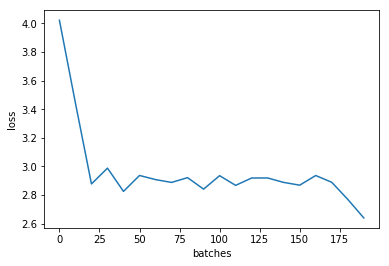




Story:
Kabul, Afghanistan  -- Explosions and heavy automatic gunfire were heard hours after five well-armed suicide bombers attacked the British Council in the Afghan capital Friday, leaving at least eight people dead, officials said.  White smoke billowed from a building in the compound while heavily armed British and Afghan forces cordoned off the area in the center of the capital, establishing a security perimeter around the buildings.  The attacks occurred inside a well-guarded Kabul neighborhood, leaving at least 16 people wounded, the Afghan Interior Ministry said.  Among the dead was one New Zealand Special Forces service member, officials said.  "I have limited details about the soldier's death, but I am advised that he died during fighting that followed an attack by insurgents in Kabul in the last few hours," New Zealand Prime Minister John Key said.  "On behalf of the government, I want to offer my condolences to the family of the soldier."  The strike, which the Taliban h

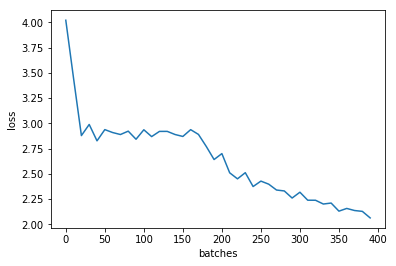




Story:
Kabul, Afghanistan  -- Explosions and heavy automatic gunfire were heard hours after five well-armed suicide bombers attacked the British Council in the Afghan capital Friday, leaving at least eight people dead, officials said.  White smoke billowed from a building in the compound while heavily armed British and Afghan forces cordoned off the area in the center of the capital, establishing a security perimeter around the buildings.  The attacks occurred inside a well-guarded Kabul neighborhood, leaving at least 16 people wounded, the Afghan Interior Ministry said.  Among the dead was one New Zealand Special Forces service member, officials said.  "I have limited details about the soldier's death, but I am advised that he died during fighting that followed an attack by insurgents in Kabul in the last few hours," New Zealand Prime Minister John Key said.  "On behalf of the government, I want to offer my condolences to the family of the soldier."  The strike, which the Taliban h

In [ ]:
batch = 0
batches = []
losses = []
for epoch in np.arange(EPOCHS):
    print('\nEpoch %d:' % epoch)
    for start_file_idx in tqdm_notebook(np.arange(0, STORIES_TO_PARSE, BATCH_SIZE)):
        end_file_idx = min(start_file_idx+BATCH_SIZE, STORIES_TO_PARSE)

        # get story and summary strings
        stories = []
        summaries = []
        for filename in story_files[start_file_idx:end_file_idx]:
            f = open(STORIES_DIR+filename, 'r')
            combo = f.read()
            splt = combo.split('@highlight')

            story = splt[0].replace('(CNN)', '').replace('\n', ' ')
            stories.append(story)

            summary = '. '.join(splt[1:]).replace('\n', '')
            summary = '\t ' + summary + ' \n'
            summaries.append(summary)

            f.close()
        N = len(stories)

        # embed stories
        stories_embeddings = np.zeros(
            (N, MAX_STORY_CHARS_TO_CONSIDER, n_characters),
            dtype='float32'
        )
        for i, story in enumerate(stories):
            for j, char in enumerate(story):
                if j < MAX_STORY_CHARS_TO_CONSIDER:
                    if char in char_2_idx:
                        k = char_2_idx[char]
                        stories_embeddings[i, j, k] = 1.
                else:
                    break        
        
        # embed summaries
        summaries_embeddings_input = np.zeros(
            (N, MAX_SUMMARY_CHARS_TO_CONSIDER, n_characters),
            dtype='float32'
        )   
        summaries_embeddings_target = np.zeros(
            (N, MAX_SUMMARY_CHARS_TO_CONSIDER, n_characters),
            dtype='float32'
        )
        for i, summary in enumerate(summaries):
            for j, char in enumerate(summary):
                if j <= MAX_SUMMARY_CHARS_TO_CONSIDER:
                    if char in char_2_idx:
                        k = char_2_idx[char]
                        if j < MAX_SUMMARY_CHARS_TO_CONSIDER:
                            summaries_embeddings_input[i, j, k] = 1.
                        if j > 0:
                            summaries_embeddings_target[i, j-1, k] = 1.
                else:
                    break

        # update model
        model.train_on_batch([stories_embeddings, summaries_embeddings_input], summaries_embeddings_target)
        if (batch % BATCHES_PER_LOSSCALC) == 0:
            batches.append(batch)
            loss = model.test_on_batch([stories_embeddings, summaries_embeddings_input], summaries_embeddings_target)
            losses.append(loss)
        batch += 1
    
    # spot check performance
    plt.plot(batches, losses)
    plt.ylabel('loss')
    plt.xlabel('batches')
    plt.show()
    plt.close()
    
    for i in np.arange(2):
        to_summarize = stories_embeddings[i].reshape(1, MAX_STORY_CHARS_TO_CONSIDER, n_characters)
        generated_summary = get_summary(to_summarize)
        print('\n\n')
        print('Story:')
        print(stories[i])
        print('\nActual Summary:')
        print(summaries[i])
        print('\nGenerated Summary:')
        print(generated_summary)

## Spot Check Performance

In [ ]:
for i in range(5):
    to_summarize = stories_embeddings[i].reshape(1, MAX_STORY_CHARS_TO_CONSIDER, n_characters)
    generated_summary = get_summary(to_summarize)
    print('\n\n')
    print('Story:')
    print(stories[i])
    print('\nActual Summary:')
    print(summaries[i])
    print('\nGenerated Summary:')
    print(generated_summary)